# Static tuning

In [1]:
import glob
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import tomli

In [2]:
DATA_DIR = Path("data/")

In [3]:
def res2data(where: Path):
    with open(where, "r") as fh:
        data = fh.readlines()
    
    seed = int(where.name.removesuffix(".txt"))

    # Only rows with instance names (we use GH200 and GH400).
    data = [row for row in data if "_2_" in row or "_4_" in row]
    rows = [datum.strip().split() for datum in data]

    return [
        (inst, seed, float(cost), int(iters))
        for inst, feas, cost, iters, time in rows
    ]

def get_size(instance: str):
    return 200 if "_2_" in instance else 400

def read(group: str, exp: int):
    instances = DATA_DIR.glob(f"{group}/{exp}.txt")
    records = itertools.chain.from_iterable([res2data(inst) for inst in instances])

    df = pd.DataFrame(records, columns=["instance", "seed", "cost", "iters"])
    df["exp"] = exp
    df["size_group"] = df["instance"].apply(get_size)

    with open(DATA_DIR / f"{group}/{exp}.toml", "rb") as fh:
        config = tomli.load(fh)

    for param, value in config[group].items():
        df[param] = value

    # Ignore scenarios with infeasible solutions.
    if df['cost'].mean() == np.inf:
        return pd.DataFrame()
        
    return df

## Population parameters

In [4]:
dfs = [read("population", exp) for exp in range(1, 501)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,exp,size_group,min_pop_size,generation_size,nb_elite,nb_close,lb_diversity,ub_diversity
0,C1_2_1,1,26986.0,284,1,200,25,40,4,5,0.1,0.5
1,C1_2_10,1,26557.0,264,1,200,25,40,4,5,0.1,0.5
2,C1_2_2,1,26943.0,309,1,200,25,40,4,5,0.1,0.5
3,C1_2_3,1,26784.0,311,1,200,25,40,4,5,0.1,0.5
4,C1_2_4,1,26487.0,205,1,200,25,40,4,5,0.1,0.5


In [5]:
fields = [
    "min_pop_size",
    "generation_size",
    "nb_elite",
    "nb_close",
    "lb_diversity",
    "ub_diversity",
]

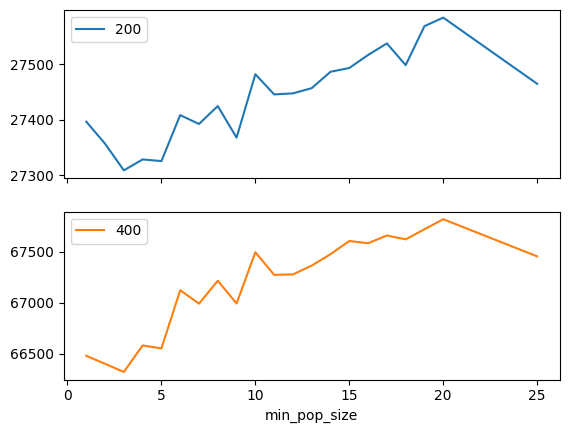

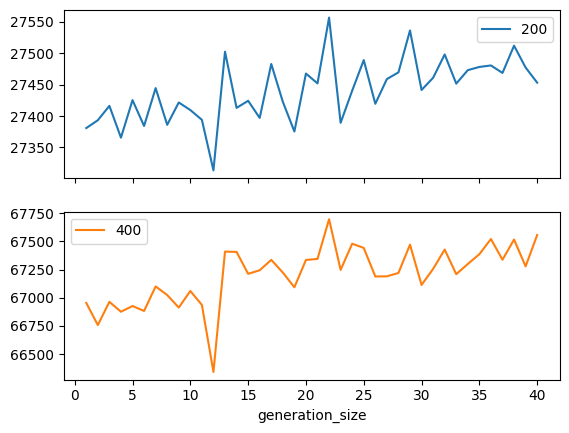

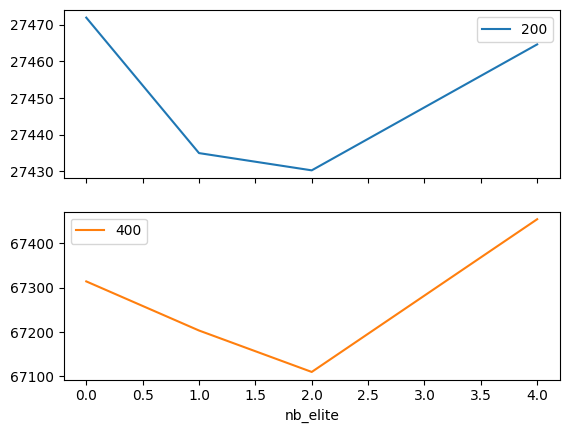

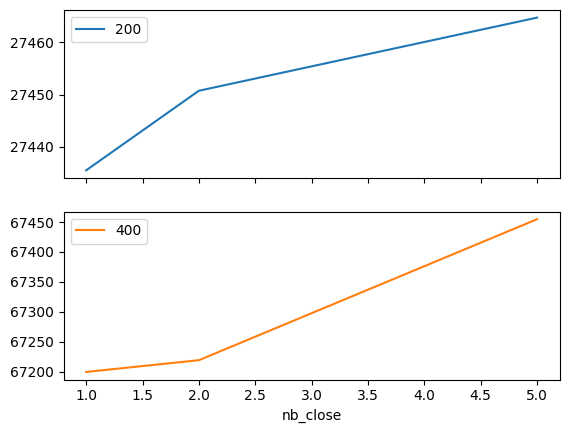

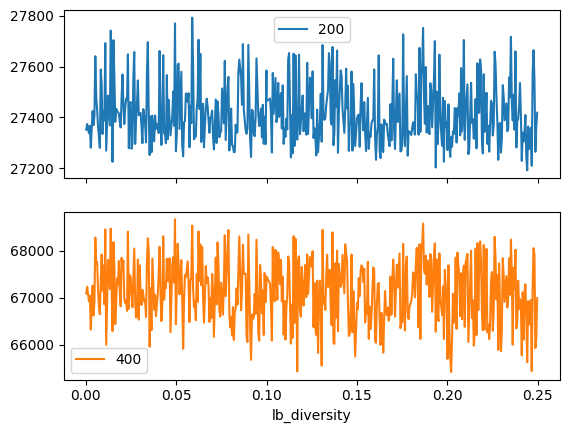

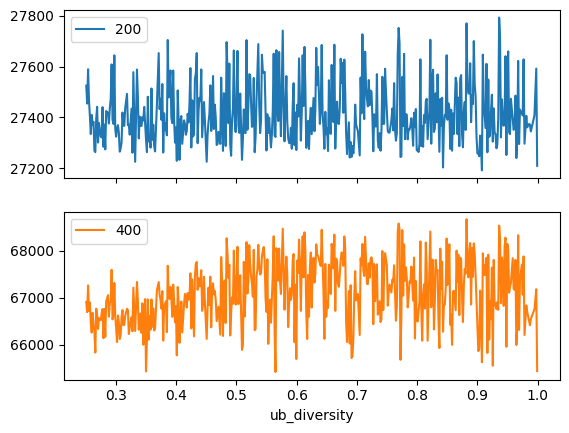

In [6]:
for field in fields:
    df.cost.groupby([df[field], df["size_group"]]).mean().unstack().plot(subplots=True);    

# Analysis

- `min_pop_size` and `generation_size` are important (which makes a lot of sense).
- `nb_elite` and `nb_close` don't matter too much, but I have chosen bad parameter bounds. (This is due to some error when nb_elite and nb_close are smaller than the population size.)
- `lb_diversity` and `ub_diversity` don't seem to matter.

In [7]:
mean_value = df[df.exp == 1].cost.mean()
print(f"{1:>3}  ----  {mean_value:.0f} (default)") 

for exp in range(2, 501):
    data = df[df.exp == exp]

    if data.empty:
        continue
        
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value and test.pvalue < 0.10:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  ----  47460 (default)
 50  0.09  46696
 97  0.09  46802
116  0.07  46735
155  0.08  46746
160  0.09  46812
188  0.07  46729
270  0.06  46413
271  0.09  46483
337  0.09  46487
342  0.07  46464
359  0.08  46504
363  0.06  46432
378  0.05  46375
379  0.06  46375
387  0.10  46520
401  0.06  46327
449  0.09  46546


Let's go for experiment 378.

```
[population]
min_pop_size = 5
generation_size = 3
nb_elite = 2
nb_close = 2
lb_diversity = 0.11698396793587175
ub_diversity = 0.34994989979959923
```

## Neighbourhood parameters

In [8]:
dfs = [read("neighbourhood", exp) for exp in range(1, 501)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,exp,size_group,weight_wait_time,weight_time_warp,nb_granular,symmetric_proximity,symmetric_neighbours
0,C1_2_1,1,26986.0,323,1,200,0.2,1.0,20,True,False
1,C1_2_10,1,26419.0,267,1,200,0.2,1.0,20,True,False
2,C1_2_2,1,26943.0,300,1,200,0.2,1.0,20,True,False
3,C1_2_3,1,26776.0,282,1,200,0.2,1.0,20,True,False
4,C1_2_4,1,26322.0,237,1,200,0.2,1.0,20,True,False


In [9]:
fields = [
    "weight_wait_time",
    "weight_time_warp",
    "nb_granular",
    "symmetric_proximity",
    "symmetric_neighbours",
]

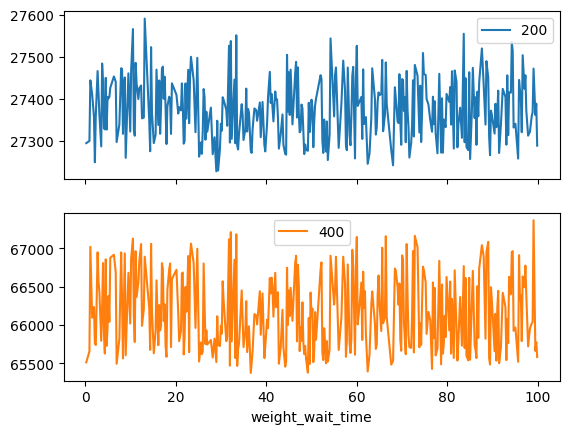

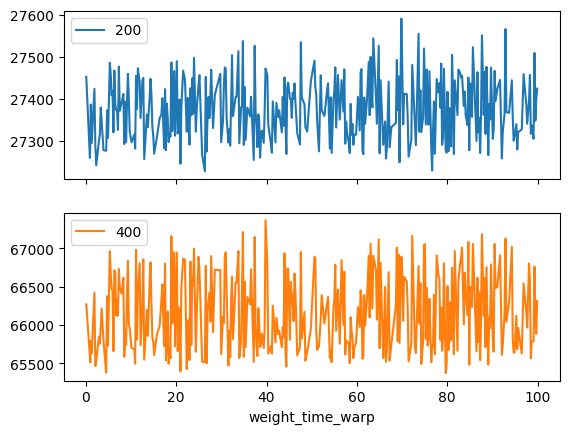

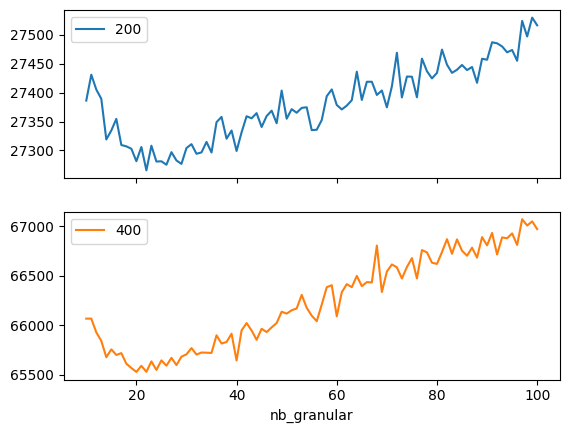

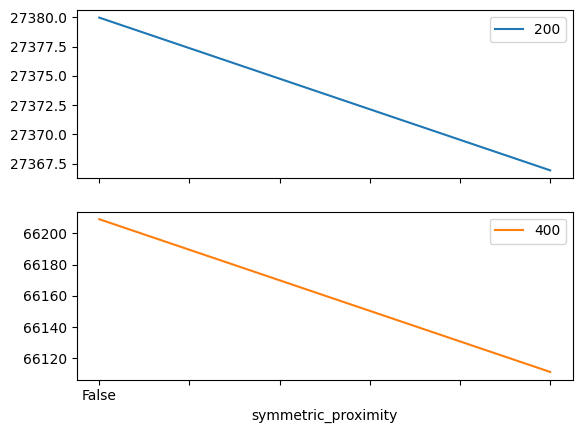

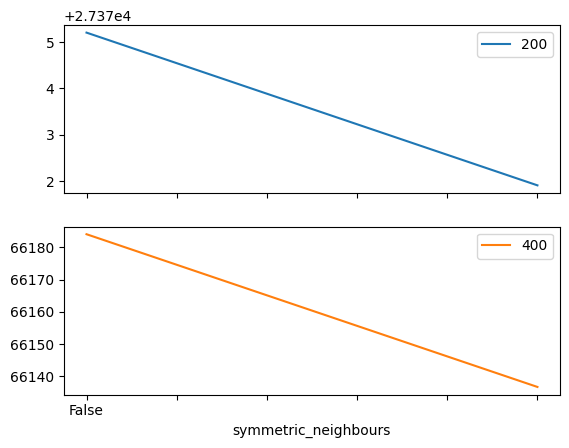

In [10]:
for field in fields:
    df.cost.groupby([df[field], df["size_group"]]).mean().unstack().plot(subplots=True);    

In [11]:
mean_value = df[df.exp == 1].cost.mean()
print(f"{1:>3}  ----  {mean_value:.0f} (default)") 

for exp in range(2, 501):
    data = df[df.exp == exp]

    if data.empty:
        continue
        
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value and test.pvalue < 0.05:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  ----  46404 (default)


No significant improvements. But it's pretty clear that decreasing the number of neighbours low to 20 is beneficial for the 200 size instances, and doesn't hurt the 400 customer instances.

## Penalty parameters

In [12]:
dfs = [read("penalty", exp) for exp in range(1, 501)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,exp,size_group,init_capacity_penalty,init_time_warp_penalty,repair_booster,num_registrations_between_penalty_updates,penalty_increase,penalty_decrease,target_feasible
0,C1_2_1,1,26986.0,496,1,200,20,6,12,50,1.34,0.32,0.43
1,C1_2_10,1,26309.0,464,1,200,20,6,12,50,1.34,0.32,0.43
2,C1_2_2,1,26943.0,429,1,200,20,6,12,50,1.34,0.32,0.43
3,C1_2_3,1,26762.0,509,1,200,20,6,12,50,1.34,0.32,0.43
4,C1_2_4,1,26265.0,403,1,200,20,6,12,50,1.34,0.32,0.43


In [13]:
fields = [
    "init_capacity_penalty",
    "init_time_warp_penalty",
    "repair_booster",
    "num_registrations_between_penalty_updates",
    "penalty_increase",
    "penalty_decrease",
    "target_feasible",
]

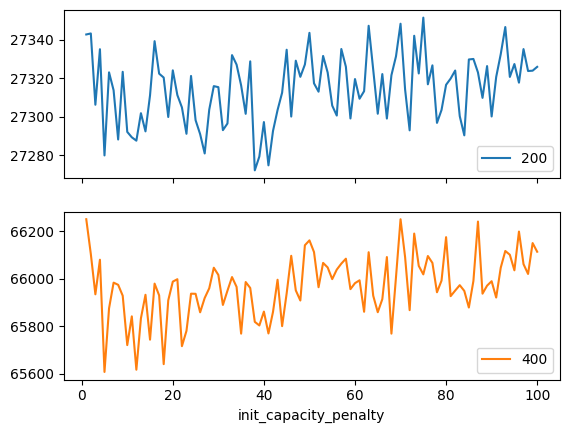

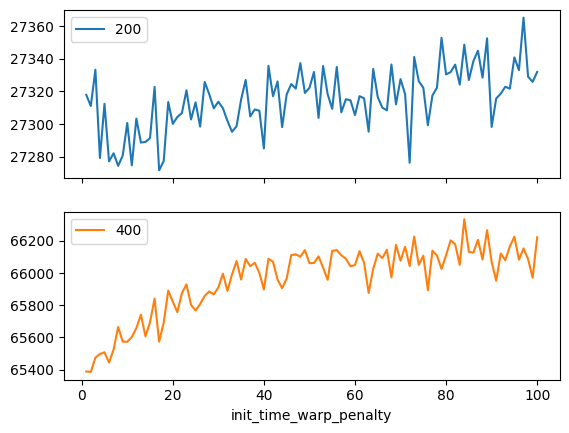

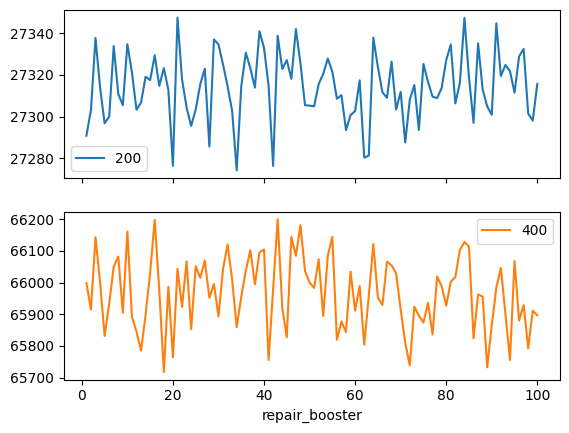

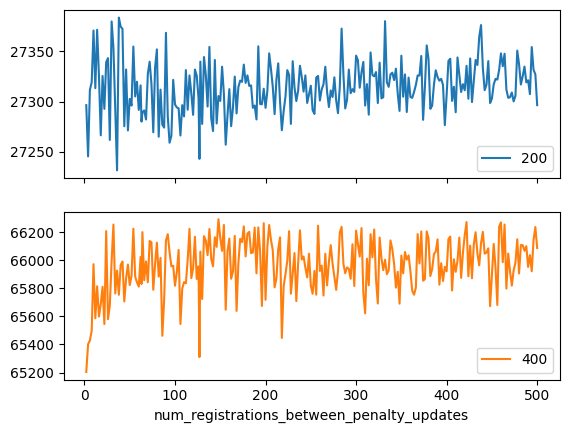

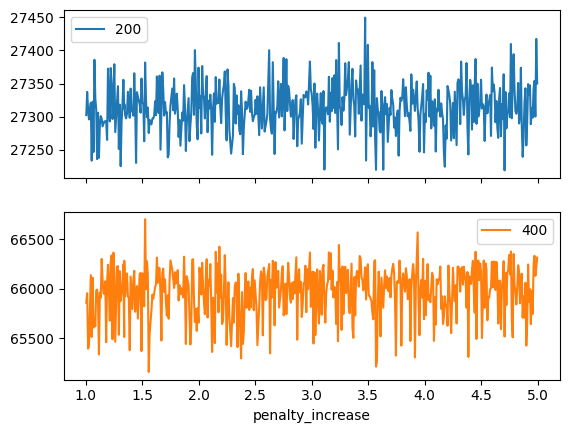

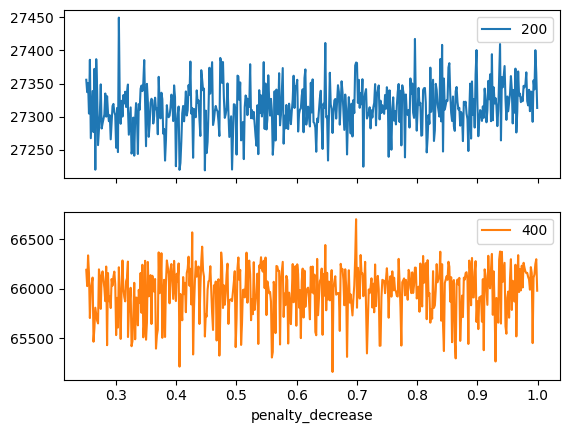

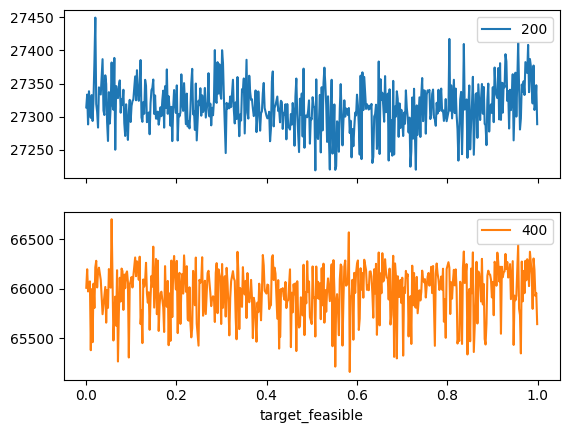

In [14]:
for field in fields:
    df.cost.groupby([df[field], df["size_group"]]).mean().unstack().plot(subplots=True);    

Is there any significant improvement?

In [15]:
mean_value = df[df.exp == 1].cost.mean()
print(f"{1:>3}  ----  {mean_value:.0f} (default)") 

for exp in range(2, 501):
    data = df[df.exp == exp]

    if data.empty:
        continue
        
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value and test.pvalue < 0.05:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  ----  46411 (default)


Nothing significant here, so we'll keep the default values.

## Node operators

In [16]:
dfs = [read("node_ops", exp) for exp in range(1, 501)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,exp,size_group,Exchange10,Exchange11,Exchange20,MoveTwoClientsReversed,Exchange21,Exchange22,Exchange30,Exchange31,Exchange32,Exchange33,TwoOpt
0,C1_2_1,1,27014.0,534,1,200,True,True,True,True,True,True,True,True,True,True,True
1,C1_2_10,1,26598.0,524,1,200,True,True,True,True,True,True,True,True,True,True,True
2,C1_2_2,1,26943.0,500,1,200,True,True,True,True,True,True,True,True,True,True,True
3,C1_2_3,1,26860.0,683,1,200,True,True,True,True,True,True,True,True,True,True,True
4,C1_2_4,1,26356.0,634,1,200,True,True,True,True,True,True,True,True,True,True,True


In [17]:
fields = [
    "Exchange10",
    "Exchange11",
    "Exchange20",
    "MoveTwoClientsReversed",
    "Exchange21",
    "Exchange22",
    "Exchange30",
    "Exchange31",
    "Exchange32",
    "Exchange33",
    "TwoOpt",
]

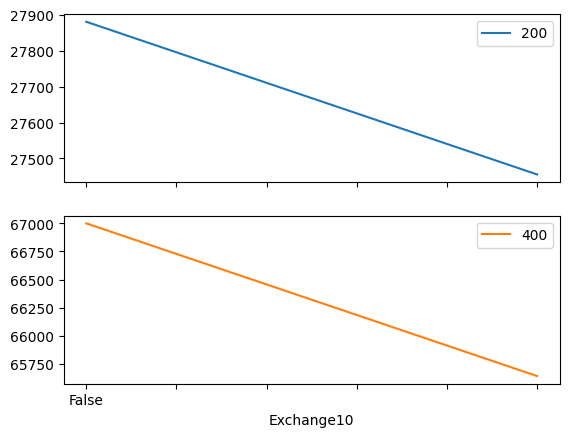

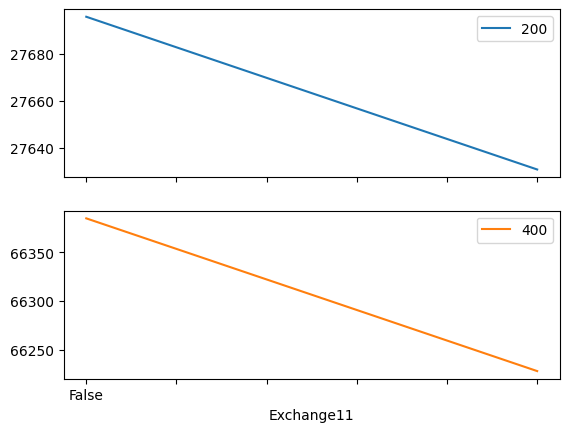

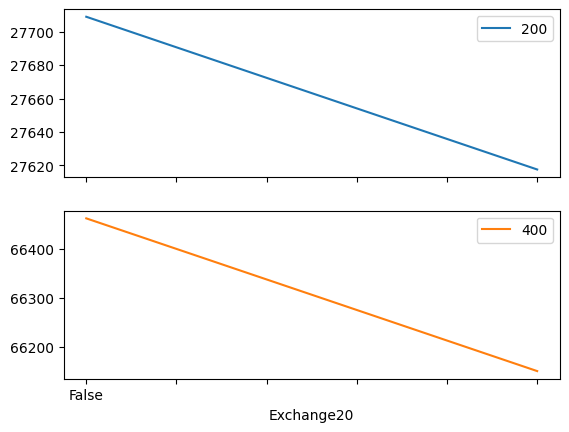

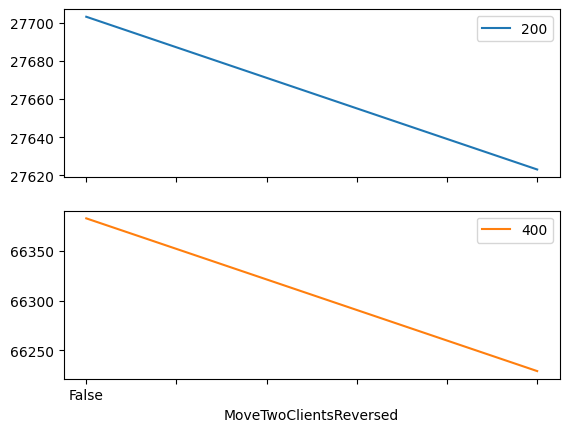

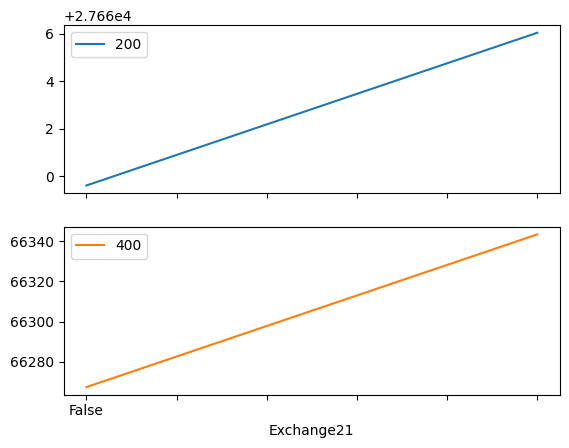

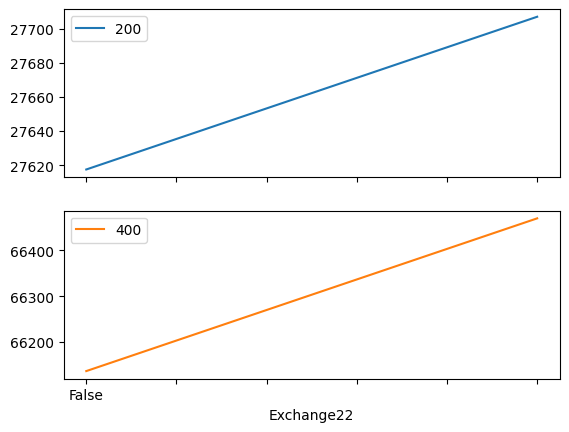

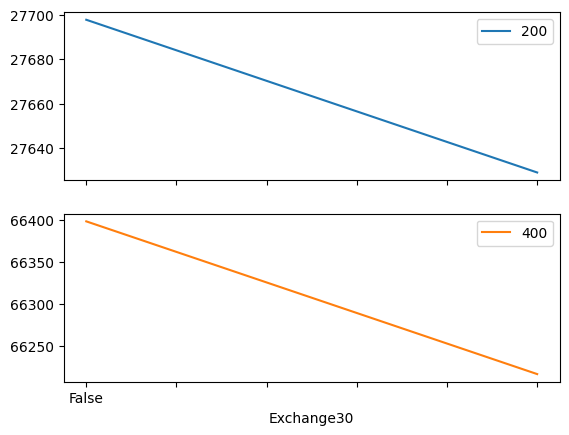

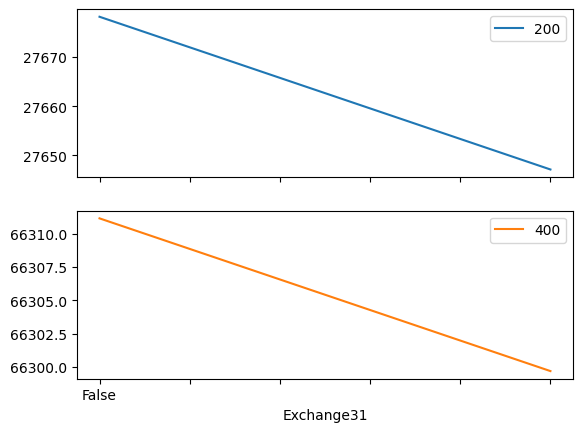

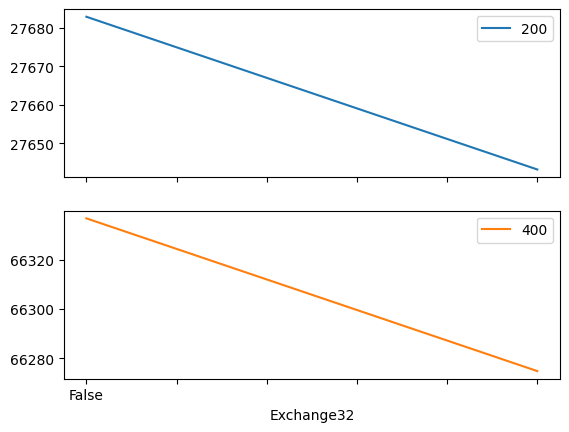

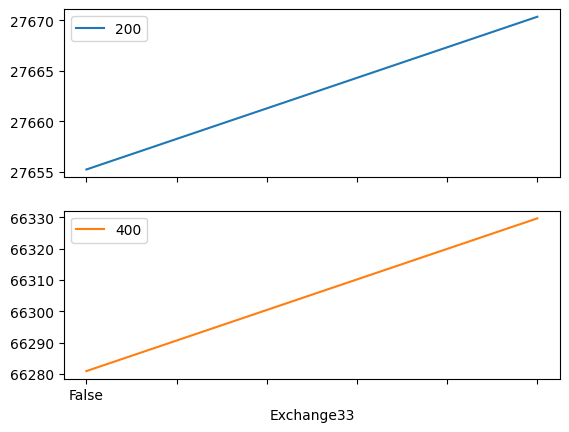

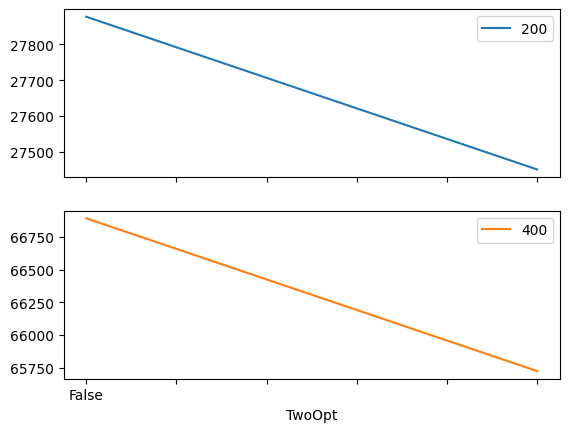

In [18]:
for field in fields:
    df.cost.groupby([df[field], df["size_group"]]).mean().unstack().plot(subplots=True);    

In [19]:
mean_value = df[df.exp == 1].cost.mean()
print(f"{1:>3}  ----  {mean_value:.0f} (default)") 

for exp in range(2, 501):
    data = df[df.exp == exp]

    if data.empty:
        continue
        
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean <= mean_value and test.pvalue < 0.05:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  ----  46413 (default)


None of the scenarios is significant. But only (1, 0) and TwoOpt seem useful. So I'll just run that.

## Route operators

In [20]:
dfs = [read("route_ops", exp) for exp in range(1, 6)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,exp,size_group,RelocateStar,SwapStar
0,C1_2_1,1,27014.0,1369,1,200,True,True
1,C1_2_10,1,26587.0,1242,1,200,True,True
2,C1_2_2,1,26943.0,1086,1,200,True,True
3,C1_2_3,1,26949.0,1439,1,200,True,True
4,C1_2_4,1,26630.0,1436,1,200,True,True


In [21]:
fields = [
    "RelocateStar",
    "SwapStar",
]

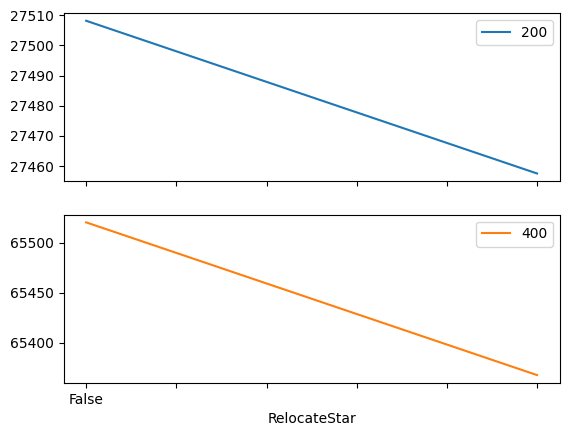

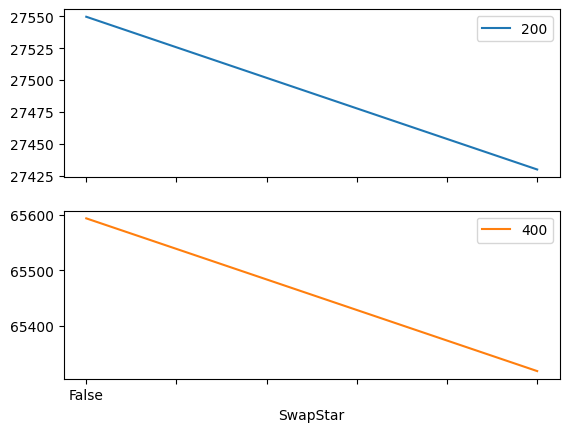

In [22]:
for field in fields:
    df.cost.groupby([df[field], df["size_group"]]).mean().unstack().plot(subplots=True);    

In [23]:
mean_value = df[df.exp == 1].cost.mean()
print(f"{1:>3}  ----  {mean_value:.0f} (default)") 

for exp in range(2, 501):
    data = df[df.exp == exp]

    if data.empty:
        continue
        
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

  1  ----  46450 (default)
  2  0.44  46356
  3  0.63  46672
  4  0.42  46317
  5  0.51  46471
